### Neural network with feedfrward for Boston House Dataset

In [9]:
# importer
import torch 
import os 
import sys
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from typing import Dict, List, Tuple
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, activation_decode, vizualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Constants

In [10]:
VALID_JSON = {
    "type":"object",
    "properties":
    {
        "data":
        {
            "type":"object",
            "property":
            {
                "path":
                {
                    "type":"string"
                },
                "src":
                {
                    "type":"array",
                    "items":
                    {
                        "type":"string",
                    }
                },
                "trg":
                {
                    "type":"string"
                },
                "test_size":
                {
                    "type":"integer",
                    "minimum":1,
                    "maximum":100
                }
            },
            "required":["path", "src", "trg", "test_size"]
        },
        "nn_config":
        {
            "type":"object",
            "properties":
            {
                "epochs":
                {
                    "type":"integer"
                },
                "batch_size":
                {
                    "type":"integer",
                },
                "act_f":
                {
                    "type":"string",
                    "enum": ["identity", "relu", "sig"]
                },
                "learning_rate":
                {
                    "type":"number",
                    "minimum": 0.0,
                    "maximum":1.0
                },
                "hidden_cnt":
                {
                    "type":"integer"
                },
                "hidden_size":
                {
                    "type":"integer"
                }
            },  
            "required":["epochs", "batch_size", "act_f", "learning_rate", "hidden_size","hidden_cnt"]
        }
    },
    "required":["data","nn_config"]
}

### Model

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, hidden_cnt:int, act_f:str)->None:
        super().__init__()
        self._input_size = input_size
        self._hidden_cnt = hidden_cnt
        self._activation = activation_decode(act_f)
        self._body = self._generate_architecture(self._input_size, hidden_size, hidden_cnt)
    
    def _generate_architecture(self, input_size:int, hidden_size:int, hidden_cnt:int)->nn.ModuleList:
        hidden = nn.ModuleList()
        hidden.append(nn.Linear(input_size, hidden_size))
        for _ in range(hidden_cnt):
            hidden.append(nn.Linear(hidden_size, hidden_size))
        hidden.append(nn.Linear(hidden_size, 1))
        return hidden

    def forward(self, x):
        x = x.view(-1, self._input_size)
        l = len(self._body)-1
        for i, layer in enumerate(self._body):
            x = layer(x)
            if i != l:
                x = self._activation(x)
        return x

### My Dataset

In [12]:

class Data(Dataset):
    def __init__(self, X:np.ndarray, y:np.ndarray) -> None:
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
    
    def __getitem__(self, index) -> Tuple:
        return self.X[index], self.y[index]
    
    def __len__(self) -> int:
        return self.len

### Working with inputs data

In [13]:
def extract_learn_data(config:Dict)->Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(config['data']['path'])
    if not config['data']['trg'] in df.columns:
        raise Exception(f'Unkown target label {config['data']['trg']}')
    if not set(config['data']['src']).issubset(df.columns):
        raise Exception(f'In source label exist unknown label.]\nInput source labels:{config['data']['src']}\nKnown labels:{df.columns}')
    X = df.loc[:, config['data']['src']].to_numpy()
    y = df.get(config['data']['trg']).to_numpy()
    return X, y

def prepare_learn_data(config:Dict, X_scaler:StandardScaler, y_scaler:StandardScaler)->Tuple[DataLoader, DataLoader]:
    X, y = extract_learn_data(config)
    y = y.reshape(-1, 1)
    X = X_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['data']['test_size']/100,random_state=42)
    return Data(X_train, y_train), Data(X_test, y_test)


### Learning process

In [14]:
def train(config:Dict, device:torch.device, model:NeuralNetwork , criterion:nn.MSELoss, optimizer:Adam, train_loader:DataLoader):
    x_epochs = np.arange(0, config['nn_config']['epochs'])
    y_loss = np.zeros(config['nn_config']['epochs'], dtype=float)

    model.train()
    for epoch in range(config['nn_config']['epochs']):
        running_loss = 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        y_loss[epoch] = running_loss/len(train_loader)
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    vizualization(x_epochs, "epochs", y_loss, "loss", "loss over epochs")
 
def test(device:torch.device, model:NeuralNetwork, test_loader:DataLoader, y_scaler:StandardScaler, criterion):
    model.eval()
    with torch.no_grad():
        loss = 0
        for banchs, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            outputs = torch.from_numpy(y_scaler.inverse_transform(model(data).cpu().detach().numpy()))
            target = torch.from_numpy(y_scaler.inverse_transform(target.cpu().detach().numpy()))
            loss += criterion(outputs, target)
        print(f'MSE Loss: {loss / (banchs + 1):.5f}')

def learning(config:Dict):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_scaler, y_scaler = StandardScaler(), StandardScaler()
    train_data, test_data = prepare_learn_data(config, X_scaler, y_scaler)
    train_loader = DataLoader(train_data, batch_size=config['nn_config']['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['nn_config']['batch_size'], shuffle=True)
    model = NeuralNetwork(train_data.X.shape[1], config['nn_config']['hidden_size'], config['nn_config']['hidden_cnt'], config['nn_config']['act_f']).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), config['nn_config']['learning_rate'])
    train(config, device,model, criterion, optimizer, train_loader)
    test(device, model, test_loader, y_scaler, criterion)


### Show relation between 

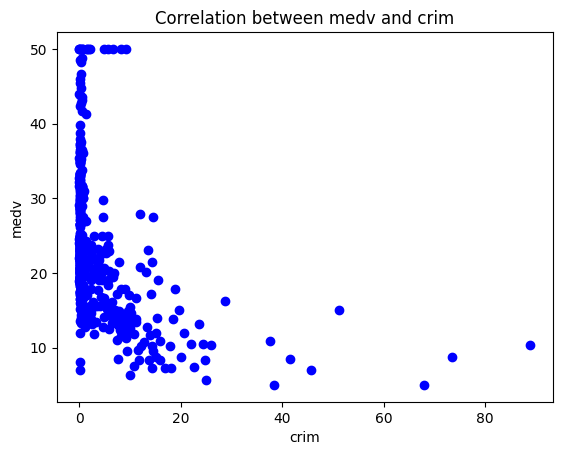

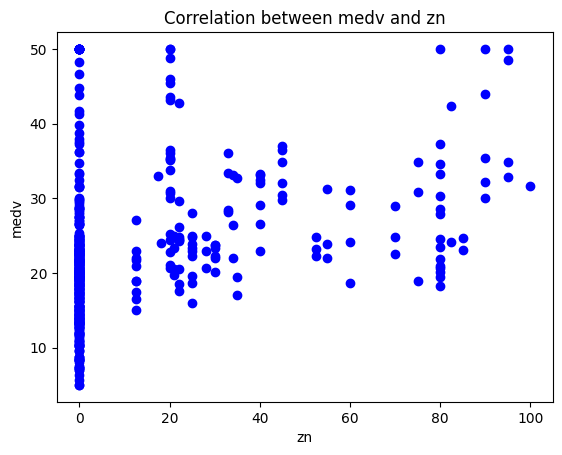

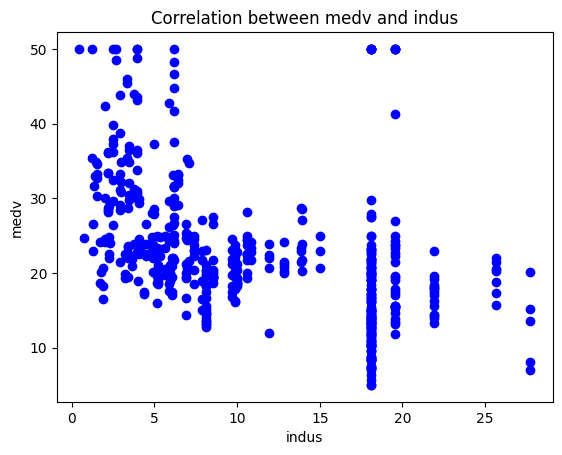

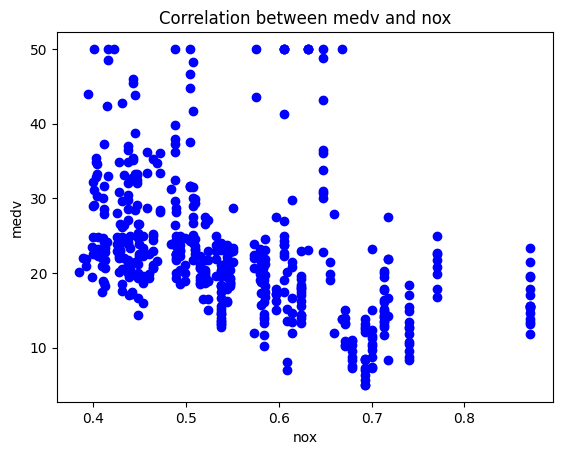

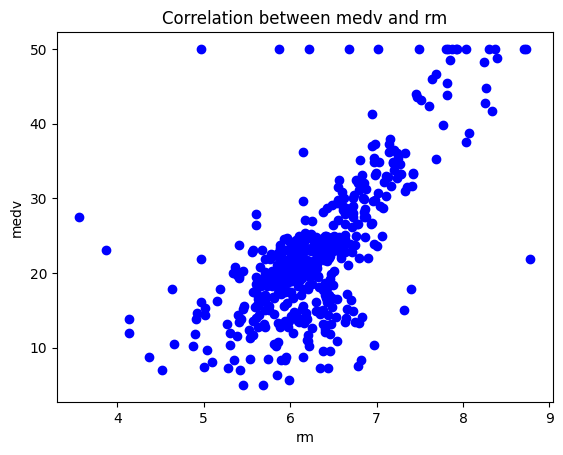

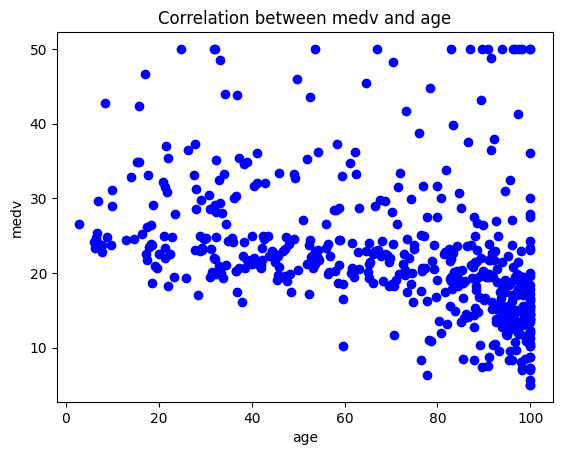

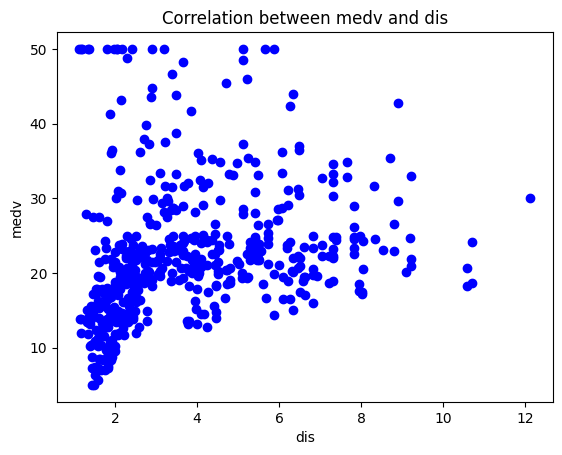

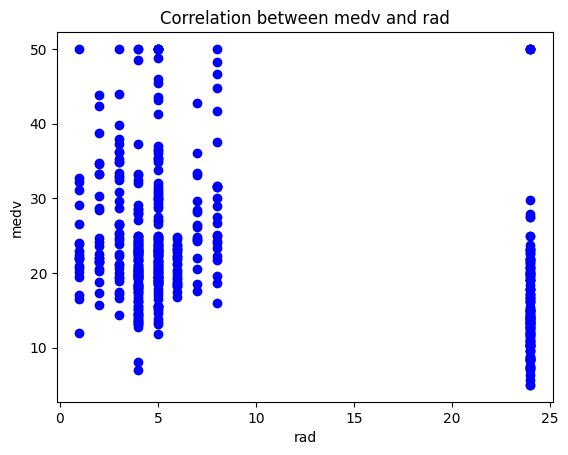

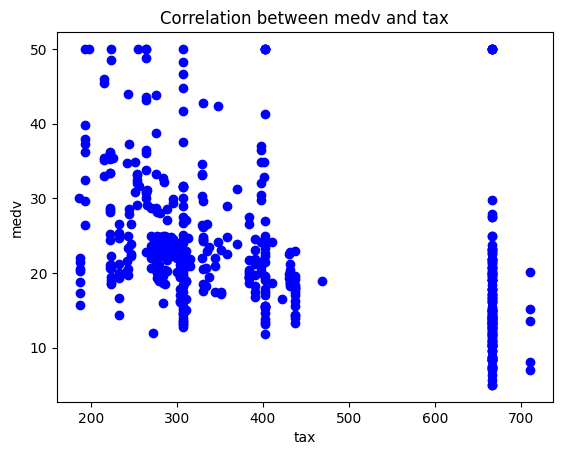

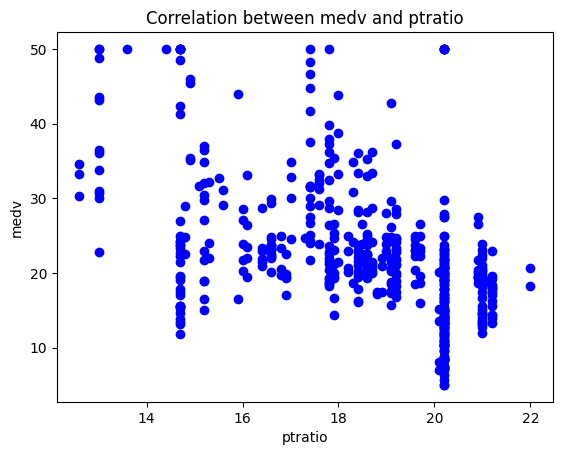

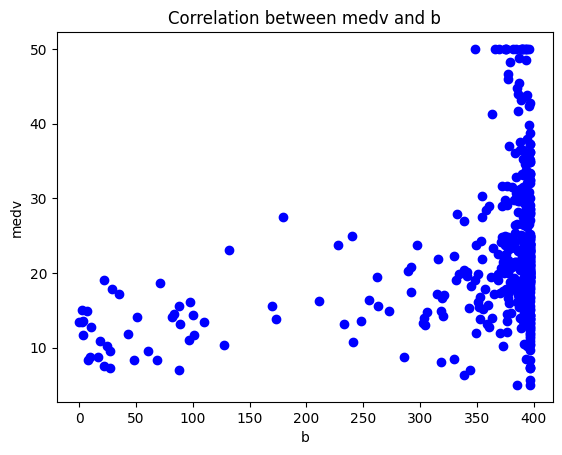

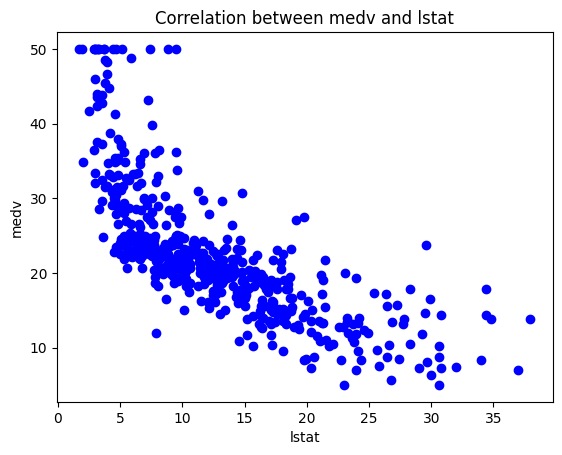

In [15]:
df = pd.read_csv('data/BostonHousing.csv')
labels = df.columns.drop('medv').drop('chas')
for label in labels:
    plt.scatter(df.get(label).to_numpy(), df.get('medv').to_numpy(), marker='o', color='blue')
    plt.xlabel(label)
    plt.ylabel('medv')
    plt.title(f'Correlation between medv and {label}')
    plt.show()

### Test 1
Use all untargets value like source

Epoch 1 finished with avg loss: 0.6234
Epoch 2 finished with avg loss: 0.4346
Epoch 3 finished with avg loss: 0.3932
Epoch 4 finished with avg loss: 0.3750
Epoch 5 finished with avg loss: 0.3618
Epoch 6 finished with avg loss: 0.3588
Epoch 7 finished with avg loss: 0.3603
Epoch 8 finished with avg loss: 0.3514
Epoch 9 finished with avg loss: 0.3538
Epoch 10 finished with avg loss: 0.3402


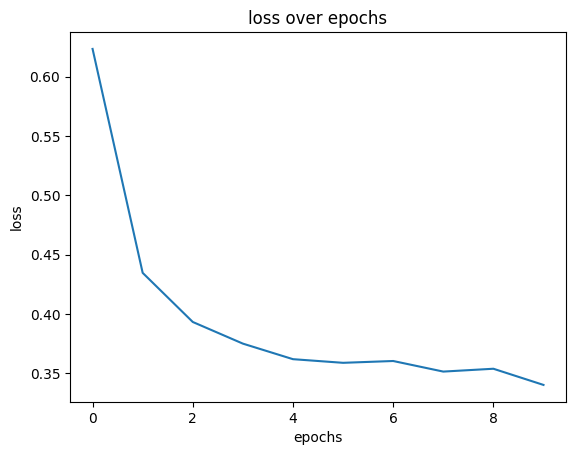

MSE Loss: 24.97849


In [16]:
config = parse_config('config/config1.json', VALID_JSON)
learning(config)

### Test 2
Use more epochs

Epoch 1 finished with avg loss: 0.5931
Epoch 2 finished with avg loss: 0.4369
Epoch 3 finished with avg loss: 0.4038
Epoch 4 finished with avg loss: 0.3773
Epoch 5 finished with avg loss: 0.3657
Epoch 6 finished with avg loss: 0.3597
Epoch 7 finished with avg loss: 0.3514
Epoch 8 finished with avg loss: 0.3500
Epoch 9 finished with avg loss: 0.3456
Epoch 10 finished with avg loss: 0.3456
Epoch 11 finished with avg loss: 0.3414
Epoch 12 finished with avg loss: 0.3388
Epoch 13 finished with avg loss: 0.3315
Epoch 14 finished with avg loss: 0.3351
Epoch 15 finished with avg loss: 0.3332
Epoch 16 finished with avg loss: 0.3354
Epoch 17 finished with avg loss: 0.3442
Epoch 18 finished with avg loss: 0.3328
Epoch 19 finished with avg loss: 0.3313
Epoch 20 finished with avg loss: 0.3301
Epoch 21 finished with avg loss: 0.3255
Epoch 22 finished with avg loss: 0.3314
Epoch 23 finished with avg loss: 0.3334
Epoch 24 finished with avg loss: 0.3324
Epoch 25 finished with avg loss: 0.3327
Epoch 26 

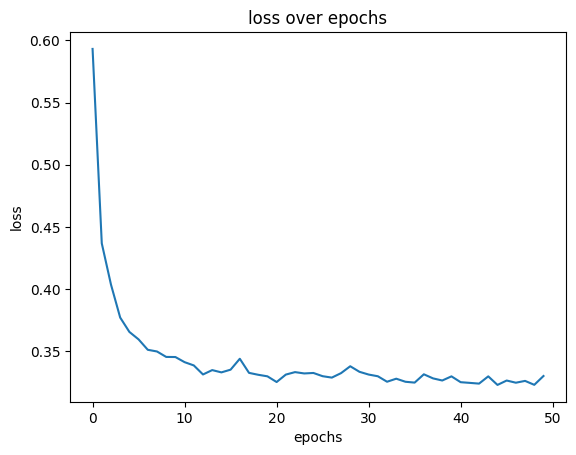

MSE Loss: 23.06006


In [17]:
config = parse_config('config/config2.json', VALID_JSON)
learning(config)

### Test 3
Use sig activation function

Epoch 1 finished with avg loss: 0.6226
Epoch 2 finished with avg loss: 0.4260
Epoch 3 finished with avg loss: 0.3793
Epoch 4 finished with avg loss: 0.3635
Epoch 5 finished with avg loss: 0.3644
Epoch 6 finished with avg loss: 0.3607
Epoch 7 finished with avg loss: 0.3707
Epoch 8 finished with avg loss: 0.3759
Epoch 9 finished with avg loss: 0.3592
Epoch 10 finished with avg loss: 0.3527


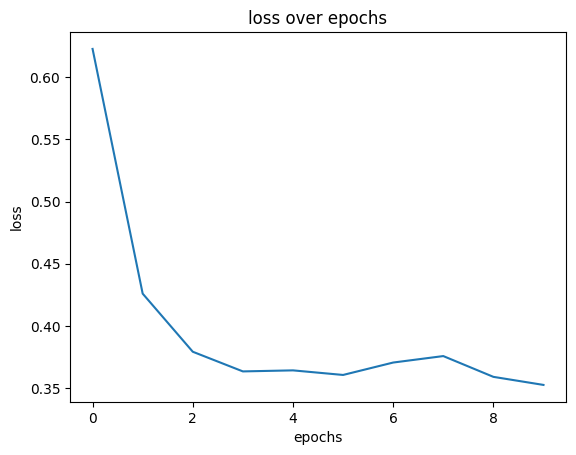

MSE Loss: 25.11459


In [18]:
config = parse_config('config/config3.json', VALID_JSON)
learning(config)

### Test 4
Use smaller(0.0001) learning rate

Epoch 1 finished with avg loss: 0.9252
Epoch 2 finished with avg loss: 0.7870
Epoch 3 finished with avg loss: 0.6711
Epoch 4 finished with avg loss: 0.5857
Epoch 5 finished with avg loss: 0.5195
Epoch 6 finished with avg loss: 0.4746
Epoch 7 finished with avg loss: 0.4436
Epoch 8 finished with avg loss: 0.4229
Epoch 9 finished with avg loss: 0.4100
Epoch 10 finished with avg loss: 0.4017


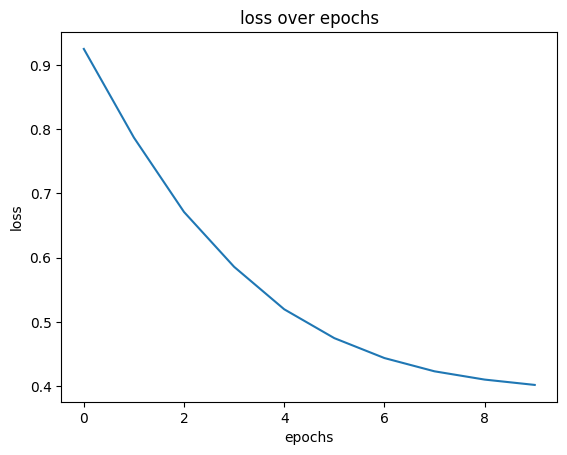

MSE Loss: 27.89579


In [19]:
config = parse_config('config/config4.json', VALID_JSON)
learning(config)

### Test 5
Use more inputs(526) to neuron

Epoch 1 finished with avg loss: 0.4855
Epoch 2 finished with avg loss: 0.3780
Epoch 3 finished with avg loss: 0.3599
Epoch 4 finished with avg loss: 0.3716
Epoch 5 finished with avg loss: 0.3485
Epoch 6 finished with avg loss: 0.3442
Epoch 7 finished with avg loss: 0.3588
Epoch 8 finished with avg loss: 0.3321
Epoch 9 finished with avg loss: 0.3403
Epoch 10 finished with avg loss: 0.3355


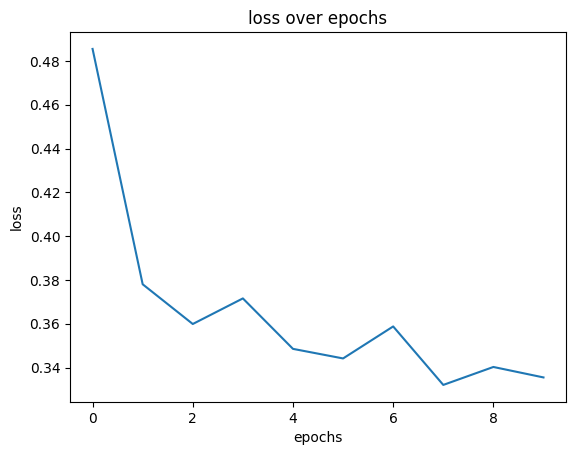

MSE Loss: 23.68932


In [20]:
config = parse_config('config/config5.json', VALID_JSON)
learning(config)

### Test 6
Less inputs(10) to neuron

Epoch 1 finished with avg loss: 1.0321
Epoch 2 finished with avg loss: 0.9748
Epoch 3 finished with avg loss: 0.9222
Epoch 4 finished with avg loss: 0.8711
Epoch 5 finished with avg loss: 0.8295
Epoch 6 finished with avg loss: 0.7844
Epoch 7 finished with avg loss: 0.7359
Epoch 8 finished with avg loss: 0.6996
Epoch 9 finished with avg loss: 0.6558
Epoch 10 finished with avg loss: 0.6227
Epoch 11 finished with avg loss: 0.5846
Epoch 12 finished with avg loss: 0.5526
Epoch 13 finished with avg loss: 0.5279
Epoch 14 finished with avg loss: 0.4993
Epoch 15 finished with avg loss: 0.4786
Epoch 16 finished with avg loss: 0.4644
Epoch 17 finished with avg loss: 0.4523
Epoch 18 finished with avg loss: 0.4396
Epoch 19 finished with avg loss: 0.4326
Epoch 20 finished with avg loss: 0.4272
Epoch 21 finished with avg loss: 0.4259
Epoch 22 finished with avg loss: 0.4196
Epoch 23 finished with avg loss: 0.4208
Epoch 24 finished with avg loss: 0.4182
Epoch 25 finished with avg loss: 0.4168
Epoch 26 

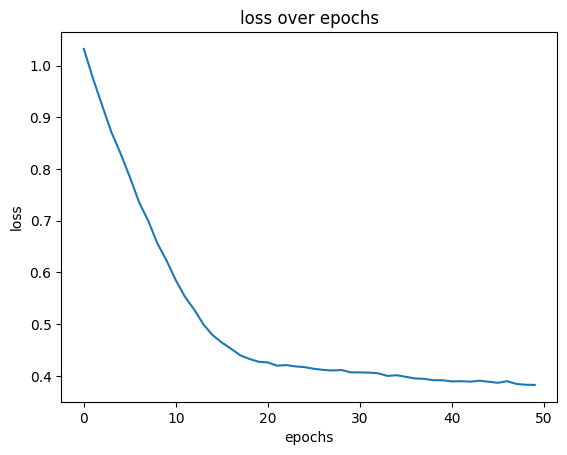

MSE Loss: 27.16170


In [21]:
config = parse_config('config/config6.json', VALID_JSON)
learning(config)

### Test 7
Use deeper neuron net(5 neurons)

Epoch 1 finished with avg loss: 0.8769
Epoch 2 finished with avg loss: 0.4993
Epoch 3 finished with avg loss: 0.4199
Epoch 4 finished with avg loss: 0.3839
Epoch 5 finished with avg loss: 0.3792
Epoch 6 finished with avg loss: 0.3557
Epoch 7 finished with avg loss: 0.3548
Epoch 8 finished with avg loss: 0.3670
Epoch 9 finished with avg loss: 0.3548
Epoch 10 finished with avg loss: 0.3471


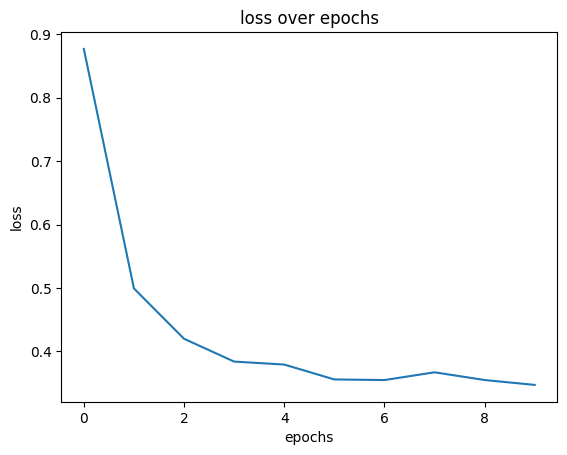

MSE Loss: 22.90057


In [22]:
config = parse_config('config/config7.json', VALID_JSON)
learning(config)

### Test 8
Use more labels for prediction

Epoch 1 finished with avg loss: 0.5108
Epoch 2 finished with avg loss: 0.2823
Epoch 3 finished with avg loss: 0.2322
Epoch 4 finished with avg loss: 0.2208
Epoch 5 finished with avg loss: 0.2081
Epoch 6 finished with avg loss: 0.2065
Epoch 7 finished with avg loss: 0.2080
Epoch 8 finished with avg loss: 0.2095
Epoch 9 finished with avg loss: 0.2009
Epoch 10 finished with avg loss: 0.1949


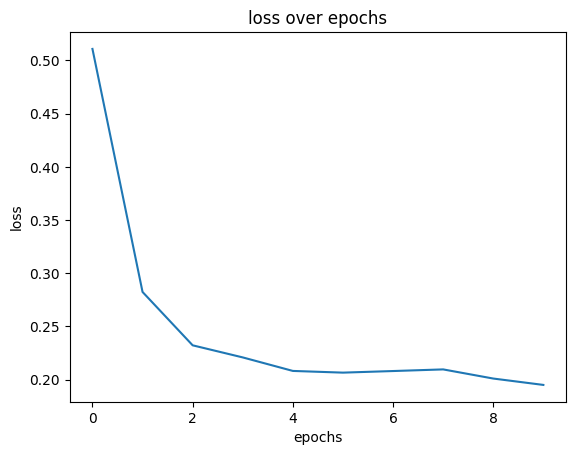

MSE Loss: 15.20145


In [23]:
config = parse_config('config/config8.json', VALID_JSON)
learning(config)